# Importamos librerias y datos

In [59]:
#from google.colab import drive
#drive.mount('/content/drive')

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
plt.rcParams["figure.figsize"] = (5, 2)
plt.rcParams['figure.dpi'] = 140

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
import plotly.express as px
from sklearn.datasets import make_classification
# hay que instalarlo aparte. 
!pip install umap-learn
import umap
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer, StandardScaler

pd.options.display.float_format = '{:.2f}'.format

In [60]:
path = 'C:/Users/Asus/Documents/GitHub/Entel---Customer-Experience/'
data = pd.read_csv(path+'base_completa_movil.csv',engine='python')

In [61]:
data = data[data['encriptado'].notna()]

### Agregando agregados

In [62]:
data = data.loc[(data['total'] >= 1000) & (data['total'] <= 10000000), :]
data = data.loc[data['n_recl_com'] <= 10, :]
data = data.loc[data['n_recl_tec'] <= 10, :]

data.loc[:, 'log_total'] = np.log(data['total'])
data.loc[:, 'churn'] = 0
data.loc[data['n_churn']>0, 'churn'] = 1
data.sort_values(by=['encriptado', 'segmento', 'periodo'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['n_recl_com_cumsum'] = data.groupby(['encriptado', 'segmento'])['n_recl_com'].transform(pd.Series.cumsum)
data['n_recl_tec_cumsum'] = data.groupby(['encriptado', 'segmento'])['n_recl_tec'].transform(pd.Series.cumsum)

Problema: Scikit no acepta variables categóricas u ordinales directamente en los clasificadores.

Podemos considerar periodo y segmento como ordinales, es decir, `2019_q1<2020_q1 `, y lo mismo para los segmentos, `masivos<mmee<empresas<ggee`

In [63]:
# data['semestre'] = 1 
# data['semestre'] = np.where(data['periodo'] == "2019_q2", 2, data['semestre'])
# data['semestre'] = np.where(data['periodo'] == "2020_q1", 3, data['semestre'])
# data['semestre'] = np.where(data['periodo'] == "2020_q2", 4, data['semestre'])

# data['seg_num'] = 1 
# data['seg_num'] = np.where(data['segmento'] == "mmee", 2, data['seg_num'])
# data['seg_num'] = np.where(data['segmento'] == "empresas", 3, data['seg_num'])
# data['seg_num'] = np.where(data['segmento'] == "ggee", 4, data['seg_num'])

data['churn_bin'] = np.where(data['n_churn']>0, 1, 0)
# fig = px.box(data, x="segmento",y="n_churn")
# fig.show()

In [42]:
data.head(3)

Unnamed: 0    encriptado  periodo segmento    total          mov_churn  \
0           1  000uDz298Xbl  2019_q1  masivos 68827.17  NA*NA*NA*NA*NA*NA   
1           2  000uDz298Xbl  2019_q2  masivos 52344.00  NA*NA*NA*NA*NA*NA   
2           3  000uDz298Xbl  2020_q1  masivos 52241.33  NA*NA*NA*NA*NA*NA   

          causa_recl          tipo_recl        estado_recl  n_recl  ...  \
0  NA*NA*NA*NA*NA*NA  NA*NA*NA*NA*NA*NA  NA*NA*NA*NA*NA*NA       0  ...   
1  NA*NA*NA*NA*NA*NA  NA*NA*NA*NA*NA*NA  NA*NA*NA*NA*NA*NA       0  ...   
2  NA*NA*NA*NA*NA*NA  NA*NA*NA*NA*NA*NA  NA*NA*NA*NA*NA*NA       0  ...   

   n_recl_tec  n_churn  comentarios nota_sem  churn_bin  semestre  log_total  \
0           0        0          NaN      nan          0         1      11.14   
1           0        0          NaN      nan          0         2      10.87   
2           0        0          NaN      nan          0         3      10.86   

   churn  n_recl_com_cumsum  n_recl_tec_cumsum  
0      0                  0                  0  
1      0                  0                  0  
2      0                  0                  0  

[3 rows x 21 columns]

Obtenemos solo datos numéricos

In [64]:
data_numerica = data[["encriptado","periodo","segmento","total","n_recl","n_recl_com","n_recl_tec",
                         "n_churn","nota_sem",'churn_bin','n_recl_com_cumsum','n_recl_tec_cumsum']]
data_numerica = pd.get_dummies(data_numerica, columns = ['periodo'])
data_numerica = pd.get_dummies(data_numerica, columns = ['segmento'])
data_numerica

encriptado    total  n_recl  n_recl_com  n_recl_tec  n_churn  \
0       000uDz298Xbl 68827.17       0           0           0        0   
1       000uDz298Xbl 52344.00       0           0           0        0   
2       000uDz298Xbl 52241.33       0           0           0        0   
3       000uDz298Xbl 50674.00       0           0           0        0   
4       001UV2eoMGlO 73405.00       0           0           0        0   
...              ...      ...     ...         ...         ...      ...   
486930  zzz48cLbzBz9 12425.67       0           0           0        0   
486931  zzzc0GgbPSR2 50418.00       0           0           0        0   
486932  zzzc0GgbPSR2 50411.00       0           0           0        0   
486933  zzzc0GgbPSR2 51452.00       0           0           0        0   
486934  zzzc0GgbPSR2 50418.00       0           0           0        0   

        nota_sem  churn_bin  n_recl_com_cumsum  n_recl_tec_cumsum  \
0            nan          0                  0                  0   
1            nan          0                  0                  0   
2            nan          0                  0                  0   
3            nan          0                  0                  0   
4            nan          0                  0                  0   
...          ...        ...                ...                ...   
486930       nan          0                  0                  0   
486931       nan          0                  0                  0   
486932       nan          0                  0                  0   
486933       nan          0                  0                  0   
486934       nan          0                  0                  0   

        periodo_2019_q1  periodo_2019_q2  periodo_2020_q1  periodo_2020_q2  \
0                     1                0                0                0   
1                     0                1                0                0   
2                     0                0                1                0   
3                     0                0                0                1   
4                     1                0                0                0   
...                 ...              ...              ...              ...   
486930                0                0                0                1   
486931                1                0                0                0   
486932                0                1                0                0   
486933                0                0                1                0   
486934                0                0                0                1   

        segmento_empresas  segmento_ggee  segmento_masivos  segmento_mmee  \
0                       0              0                 1              0   
1                       0              0                 1              0   
2                       0              0                 1              0   
3                       0              0                 1              0   
4                       0              0                 1              0   
...                   ...            ...               ...            ...   
486930                  0              0                 1              0   
486931                  0              0                 1              0   
486932                  0              0                 1              0   
486933                  0              0                 1              0   
486934                  0              0                 1              0   

        segmento_s/i  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
486930             0  
486931             0  
486932             0  
486933             0  
486934             0  

[486935 rows x 19 columns]

# Balanceamos las clases

In [65]:
data_numerica2= data_numerica.loc[:, ~data_numerica.columns.isin(['nota_sem','encriptado'])]
data_numerica2['log_total'] = np.log(data_numerica2['total'])
data_numerica2=data_numerica2.dropna()
X= data_numerica2.loc[:, ~data_numerica2.columns.isin(['churn_bin','n_churn','total'])]
y=data_numerica2['churn_bin']

<ipython-input-65-84c5661388e6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
#Luego esta data la dividimos en test y train
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(X), pd.DataFrame(y), test_size=0.33, shuffle=True)


smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 420573, 1: 66362})
Resample dataset shape Counter({'churn_bin': 1})


# Algoritmos de ML para predecir churn

### Árbol de decisión

In [46]:
tree = DecisionTreeClassifier(criterion='entropy')
tree = tree.fit(x_smote, y_smote)
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.68      0.78    138732
           1       0.20      0.49      0.28     21957

    accuracy                           0.66    160689
   macro avg       0.55      0.59      0.53    160689
weighted avg       0.80      0.66      0.71    160689



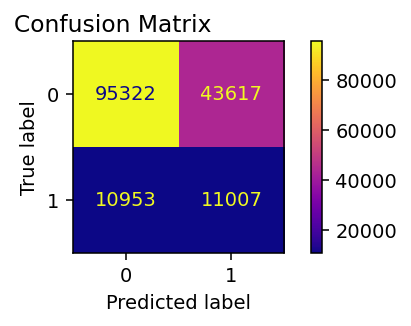

In [15]:
disp = plot_confusion_matrix(tree, X_test, y_test,cmap='plasma')
disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

### Random Forest

In [48]:
rf = RandomForestClassifier(
            n_estimators = 10,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123)
rf.fit(x_smote, y_smote)
print(classification_report(y_test, rf.predict(X_test)))

<ipython-input-48-a5427df3d842>:8: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



              precision    recall  f1-score   support

           0       0.89      0.70      0.79    138732
           1       0.20      0.47      0.28     21957

    accuracy                           0.67    160689
   macro avg       0.55      0.59      0.53    160689
weighted avg       0.80      0.67      0.72    160689



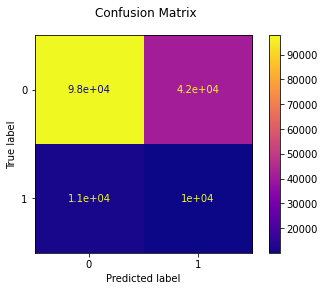

In [13]:
disp = plot_confusion_matrix(rf, X_test, y_test,cmap='plasma')
disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

Feature: 0, Score: 0.00820
Feature: 1, Score: 0.00424
Feature: 2, Score: 0.00123
Feature: 3, Score: 0.00054
Feature: 4, Score: 0.00046
Feature: 5, Score: 0.00061
Feature: 6, Score: 0.00087
Feature: 7, Score: 0.00155
Feature: 8, Score: 0.01242
Feature: 9, Score: 0.03159
Feature: 10, Score: 0.00321
Feature: 11, Score: 0.00106
Feature: 12, Score: 0.93403


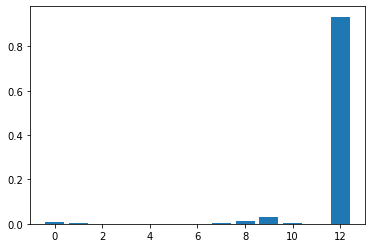

In [14]:
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Logistic Regression

In [15]:
LogisticRegression=LogisticRegression()
LogisticRegression.fit(x_smote, y_smote)
print(classification_report(y_test, LogisticRegression.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



              precision    recall  f1-score   support

           0       0.90      0.80      0.85    139304
           1       0.25      0.43      0.32     21595

    accuracy                           0.75    160899
   macro avg       0.58      0.62      0.59    160899
weighted avg       0.81      0.75      0.78    160899



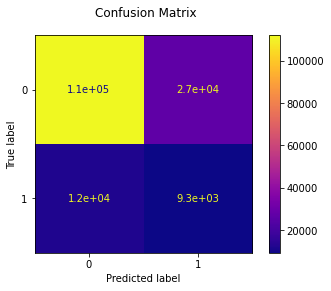

In [16]:
disp = plot_confusion_matrix(LogisticRegression, X_test, y_test,cmap='plasma')

disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

### Gaussian Naive Bayes

In [17]:
GaussianNB=GaussianNB()
GaussianNB.fit(x_smote, y_smote)
print(classification_report(y_test, GaussianNB.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00    139304
           1       0.13      1.00      0.24     21595

    accuracy                           0.14    160899
   macro avg       0.57      0.50      0.12    160899
weighted avg       0.88      0.14      0.03    160899



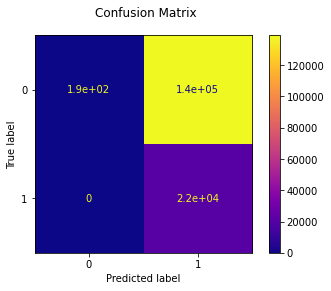

In [18]:
disp = plot_confusion_matrix(GaussianNB, X_test, y_test,cmap='plasma')
disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

### SVM

In [19]:
svm = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=0.000000001, max_iter=1000))
svm.fit(x_smote, y_smote)
print(classification_report(y_test, svm.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



              precision    recall  f1-score   support

           0       0.90      0.81      0.85    139304
           1       0.26      0.42      0.32     21595

    accuracy                           0.76    160899
   macro avg       0.58      0.62      0.59    160899
weighted avg       0.81      0.76      0.78    160899



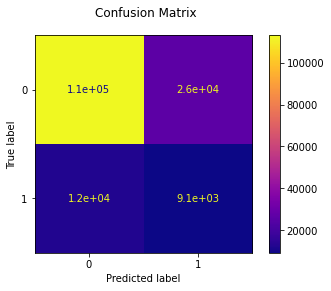

In [20]:
disp = plot_confusion_matrix(svm, X_test, y_test,cmap='plasma')
disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
# defining parameter range
param_grid = {'kernel': ['rbf','linear', 'poly']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(x_smote, y_smote)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

# Problema de satisfacción

In [66]:
data_satis = data_numerica[data_numerica['nota_sem'].notna()].reset_index() #obtenemos solo datos de quienes han respondido encuestras
data_satis['log_total'] = np.log(data_satis['total'])
data_satis['satisfecho'] = np.where(data_satis['nota_sem']>6, 1, 0)
data_satis=data_satis.dropna()
data_satis=data_satis.loc[:, ~data_satis.columns.isin(['index'])]
data_satis.head(4)

encriptado     total  n_recl  n_recl_com  n_recl_tec  n_churn  nota_sem  \
0  0038pSh9f6sB 169714.67       0           0           0        0      5.00   
1  008SWHtOqEsn 374834.83       0           0           0        0      5.00   
2  00EERydraWsu 131338.00       0           0           0        0      7.00   
3  00EERydraWsu 132170.00       1           1           0        0      6.00   

   churn_bin  n_recl_com_cumsum  n_recl_tec_cumsum  ...  periodo_2019_q2  \
0          0                  0                  0  ...                0   
1          0                  0                  0  ...                0   
2          0                  0                  0  ...                0   
3          0                  1                  0  ...                1   

   periodo_2020_q1  periodo_2020_q2  segmento_empresas  segmento_ggee  \
0                0                1                  0              0   
1                0                1                  0              1   
2                0                0                  1              0   
3                0                0                  1              0   

   segmento_masivos  segmento_mmee  segmento_s/i  log_total  satisfecho  
0                 0              1             0      12.04           0  
1                 0              0             0      12.83           0  
2                 0              0             0      11.79           1  
3                 0              0             0      11.79           0  

[4 rows x 21 columns]

In [67]:
data_num_sat= data_satis.loc[:, ~data_satis.columns.isin(['nota_sem','total','encriptado'])]
#X= data_num_sat.loc[:, ~data_num_sat.columns.isin(['total','encriptado','satisfecho'])]
#y=data_num_sat['satisfecho']
# from statsmodels.api import OLS
# OLS(y,X).fit().summary()

In [68]:
data_knn_agrupar= data_satis.loc[:, ~data_satis.columns.isin(['segmento','periodo','log_total','nota_sem','encriptado'])]
data_knn= data_satis.loc[:, ~data_satis.columns.isin(['encriptado','segmento','periodo','total','nota_sem'])]

In [70]:
# Usamos metodo del codo para escoger el k que mejor ajusta el cluster.
elbow = pd.DataFrame(columns=['SSE','k'])


for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_knn)
    elbow = elbow.append({'SSE': kmeans.inertia_, 'k': k}, ignore_index=True)

# Son ploteados los Resultados
fig = go.Figure(data=[
    go.Scatter(x = elbow.k, y=elbow.SSE, mode='lines'),
    go.Scatter(x = elbow.k, y=elbow.SSE, mode='markers')
])

fig.update_layout(title="Evaluación de los Clusters (Metodo del Codo):",
                 xaxis_title = "Numero de Clusters:",
                 yaxis_title = "SSE",
                 showlegend=False)
fig.show()

Realizaremos la reducción de dimensionalidad en los datos

In [71]:
data_knn_agrupar_prev=data_knn_agrupar.copy()
data_knn_agrupar_prev= data_knn_agrupar_prev.loc[:, ~data_knn_agrupar_prev.columns.isin(['encriptado'])]
# Notar que hacemos un escalamiento previo!!
scaled_features = StandardScaler().fit_transform(data_knn_agrupar_prev)
normalized_features = Normalizer().fit_transform(scaled_features)
features_df = pd.DataFrame(normalized_features, columns=data_knn_agrupar_prev.columns)

umap_embedded = umap.UMAP().fit_transform(features_df)
# Noten que guardamos la transformación en df y no en features.

In [77]:
k=2
model = KMeans(n_clusters=k, random_state=80)
model.fit(features_df)
features_df["Cluster"] = model.labels_
data_knn_agrupar2=features_df.copy()
C2=data_knn_agrupar2.groupby('Cluster').agg({'n_recl':'mean', 
                         'n_recl_com':'mean', 
                         'n_recl_tec':'mean', 
                         'n_churn':'mean',
                         'total':'mean',
                         'churn_bin':'mean',
                         'satisfecho':'mean'})
C2

n_recl  n_recl_com  n_recl_tec  n_churn  total  churn_bin  satisfecho
Cluster                                                                       
0         -0.06       -0.05       -0.05    -0.07  -0.12      -0.08       -0.02
1         -0.02       -0.02       -0.02    -0.00   0.02       0.01        0.00

In [73]:
X_map2= data_knn_agrupar2.loc[:, ~data_knn_agrupar2.columns.isin(['encriptado'])]
X_map2['x_umap'] = umap_embedded[:, 0]
X_map2['y_umap'] = umap_embedded[:, 1]

px.scatter(
    X_map2,
    x='x_umap',
    y='y_umap',
    labels={
                     "x_umap": "",
                     "y_umap": ""
                 },
    color='Cluster',width=600, height=400
)

In [78]:
k=3
model = KMeans(n_clusters=k, random_state=80)
model.fit(features_df)
features_df["Cluster"] = model.labels_
data_knn_agrupar3=features_df.copy()
C3=data_knn_agrupar3.groupby('Cluster').agg({'n_recl':'mean', 
                         'n_recl_com':'mean', 
                         'n_recl_tec':'mean', 
                         'n_churn':'mean',
                         'total':'mean',
                         'churn_bin':'mean',
                         'satisfecho':'mean'})
C3

n_recl  n_recl_com  n_recl_tec  n_churn  total  churn_bin  satisfecho
Cluster                                                                       
0         -0.00       -0.01       -0.00     0.03   0.12       0.06        0.01
1         -0.06       -0.05       -0.05    -0.07  -0.12      -0.08       -0.02
2         -0.04       -0.03       -0.03    -0.05  -0.09      -0.05       -0.02

In [ ]:
X_map3= data_knn_agrupar3.loc[:, ~data_knn_agrupar3.columns.isin(['encriptado'])]
X_map3['x_umap'] = umap_embedded[:, 0]
X_map3['y_umap'] = umap_embedded[:, 1]

px.scatter(
    X_map3,
    x='x_umap',
    y='y_umap',
    color='Cluster',width=600, height=400
)

In [ ]:
k=4
model = KMeans(n_clusters=k, random_state=80)
model.fit(features_df)
features_df["Cluster"] = model.labels_
data_knn_agrupar2=features_df.copy()
C4=data_knn_agrupar4.groupby('Cluster').agg({'n_recl':'mean', 
                         'n_recl_com':'mean', 
                         'n_recl_tec':'mean', 
                         'n_churn':'mean',
                         'total':'mean',
                         'churn_bin':'mean',
                         'satisfecho':'mean',
                         'satisfecho':'count'})
C4

In [ ]:
X_map4= data_knn_agrupar4.loc[:, ~data_knn_agrupar4.columns.isin(['encriptado'])]
X_map4['x_umap'] = umap_embedded[:, 0]
X_map4['y_umap'] = umap_embedded[:, 1]

px.scatter(
    X_map4,
    x='x_umap',
    y='y_umap',
    color='Cluster',width=600, height=400
)

In [ ]:
k=5
model = KMeans(n_clusters=k, random_state=80)
model.fit(data_knn)
data_knn_agrupar["Cluster"] = model.labels_
data_knn_agrupar5=data_knn_agrupar.copy()

C5=data_knn_agrupar5.groupby('Cluster').agg({'n_recl':'mean', 
                         'n_recl_com':'mean', 
                         'n_recl_tec':'mean', 
                         'n_churn':'mean',
                         'total':'mean',
                         'churn_bin':'mean',
                         'satisfecho':'mean',
                         'satisfecho':'count'})
C5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



n_recl  n_recl_com  n_recl_tec  ...      total  churn_bin  satisfecho
Cluster                                  ...                                  
0          0.29        0.17        0.11  ...  962536.34       0.57        5513
1          1.66        1.17        0.37  ... 3772442.51       1.00         126
2          0.06        0.03        0.02  ...  123328.67       0.10       11130
3          0.53        0.30        0.16  ... 1289670.79       1.00         924
4          2.72        1.67        0.83  ... 9809872.11       1.00          18

[5 rows x 7 columns]

In [ ]:
X_map5= data_knn_agrupar5.loc[:, ~data_knn_agrupar5.columns.isin(['encriptado'])]
X_map5['x_umap'] = umap_embedded[:, 0]
X_map5['y_umap'] = umap_embedded[:, 1]

px.scatter(
    X_map5,
    x='x_umap',
    y='y_umap',
    color='Cluster',width=600, height=400
)

In [ ]:
from sklearn.cluster import DBSCAN

epss = np.arange(1 , 2, 0.2)

clustering = [DBSCAN(eps=eps, min_samples=2).fit_predict(scaled_features) for eps in epss]
dbscan_labels = pd.DataFrame(np.array(clustering)).T
dbscan_labels.columns = epss

dbscan_labels['x'] = X_map5['x_umap']
dbscan_labels['y'] = X_map5['y_umap']

dbscan_labels = dbscan_labels.melt(id_vars=['x', 'y'], var_name='eps', value_name='label')
dbscan_labels['label'] = dbscan_labels['label'].astype(str)
dbscan_labels.sample(10)


x     y  eps label
46867 -1.98 16.01 1.40    16
82368  3.92  3.51 1.80     0
52023 13.10  2.06 1.40    -1
75816  6.16  0.86 1.80    44
3842  20.54  8.43 1.00    12
57854  5.43  9.55 1.60     5
68482 -3.22  0.01 1.60    45
59894 18.76  9.88 1.60    39
42783 -3.93 10.74 1.40    21
62345  4.29  5.86 1.60     5

In [ ]:
from sklearn.datasets import make_blobs
from sklearn import metrics

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(scaled_features)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 90
Estimated number of noise points: 2078


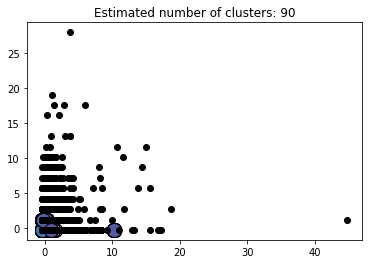

In [ ]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = scaled_features[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = scaled_features[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


In [ ]:
fig = px.scatter(
    dbscan_labels,
    x="x",
    y="y",
    facet_row='eps',
    color='label',
    height=1600
)
fig.show()


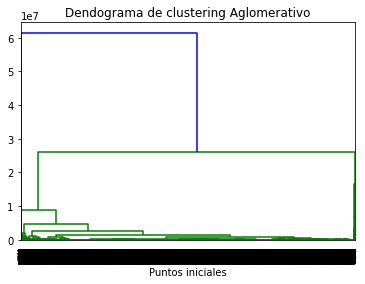

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    
    plt.title('Dendograma de clustering Aglomerativo')
    plt.xlabel("Puntos iniciales")

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix,**kwargs)
    
    plt.show()



model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')

model = model.fit(data_knn_agrupar)

# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level')


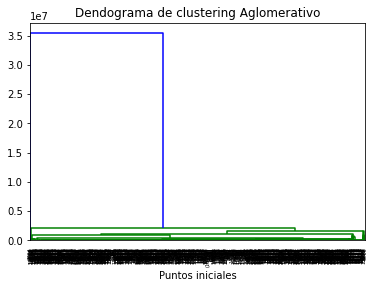

In [ ]:

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model = model.fit(data_knn_agrupar)

# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level')

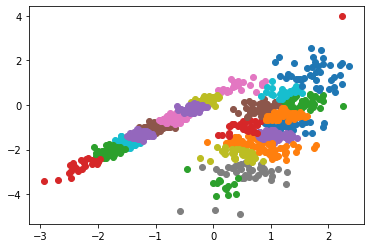

In [ ]:
# affinity propagation clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot
# define dataset
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = AffinityPropagation(damping=0.9)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()